<a href="https://colab.research.google.com/github/NBSimo/TFG-Simo-Navarro-Bria/blob/main/TFG_NBSIMO_Classificador_Cacuet_Closca_Hiperespectral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#llibreries necessaries pel programa 
import tensorflow as tf
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools


In [ ]:
#iniciar sessió per l'acces al conjunt d'imatges
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
train_path = '/content/drive/MyDrive/Dataset2/training'
test_path = '/content/drive/MyDrive/Dataset2/test'
valid_path = '/content/drive/MyDrive/Dataset2/validation'

IMAGE_SIZE = [100,100]
train_datagen = []
test_datagen = []

In [ ]:
#fem un pre-procès on analitzem les nostres carpetes del directori i etiquetem com a cacauets i closques les imatges, definint un 
#utilitzem el model VGG16 per fer aques pre entrenament  que es un modul de classficacio adient
#definim el BATCH size a 10
#shuffle FALSE
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(100,100), classes=['cacauets', 'closques'], batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(100,100), classes=['cacauets', 'closques'], batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(100,100), classes=['cacauets', 'closques'], batch_size=10, shuffle=False)

Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [ ]:
#cridem la funcio next per generar un conjunt de dades aleatories per poder observar les etiquetes  
imgs, labels = next(train_batches)

In [ ]:
#codi extret de la scykitlearn
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

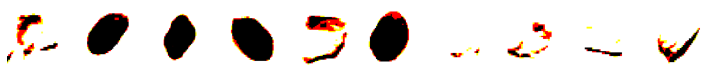

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [ ]:
#agafem 10 imatges aleatoriers per tal de veure quina etiqueta sels hi dona i si correspon i ho ho fem correctament
plotImages(imgs)
print(labels)

In [ ]:
#Definim el nostre model secuencial amb 3 capes de convolucio i 3 de maxpooling i filtres de 3x3 de tamany. Es treballa en RGB per la poca quanitat de pixels en la imatge
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(100,100,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

In [ ]:
model.summary() 

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 25, 25, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 25, 25, 64)        36928     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 12, 12, 64)      

In [ ]:
#utilitzem Adam com a optimitzadorm, categorical corssentropy que ens serveix per veure la probabilitat de pertanyer a un grup o un altre. Avaluem amb la preccisió
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=30,
    verbose=2
)

Epoch 1/30
10/10 - 1s - loss: 2.9104 - accuracy: 0.7500 - val_loss: 0.0390 - val_accuracy: 0.9900 - 1s/epoch - 120ms/step
Epoch 2/30
10/10 - 0s - loss: 4.9926e-04 - accuracy: 1.0000 - val_loss: 0.1925 - val_accuracy: 0.9800 - 415ms/epoch - 42ms/step
Epoch 3/30
10/10 - 0s - loss: 0.1200 - accuracy: 0.9700 - val_loss: 5.7380e-05 - val_accuracy: 1.0000 - 426ms/epoch - 43ms/step
Epoch 4/30
10/10 - 0s - loss: 0.0251 - accuracy: 0.9900 - val_loss: 0.0023 - val_accuracy: 1.0000 - 407ms/epoch - 41ms/step
Epoch 5/30
10/10 - 0s - loss: 7.6054e-07 - accuracy: 1.0000 - val_loss: 0.2571 - val_accuracy: 0.9800 - 414ms/epoch - 41ms/step
Epoch 6/30
10/10 - 0s - loss: 0.1278 - accuracy: 0.9900 - val_loss: 8.2468e-04 - val_accuracy: 1.0000 - 406ms/epoch - 41ms/step
Epoch 7/30
10/10 - 0s - loss: 1.8202e-05 - accuracy: 1.0000 - val_loss: 0.3247 - val_accuracy: 0.9700 - 443ms/epoch - 44ms/step
Epoch 8/30
10/10 - 0s - loss: 0.0144 - accuracy: 0.9900 - val_loss: 0.1618 - val_accuracy: 0.9800 - 431ms/epoch - 

In [ ]:
test_imgs, test_labels = next(test_batches)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

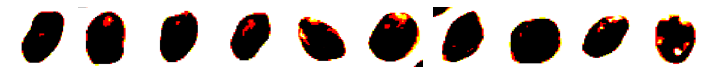

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
plotImages(test_imgs)
print(test_labels)

In [ ]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [ ]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
#Codi extret directe de la web de Scikit learn
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[300   0]
 [  0 300]]


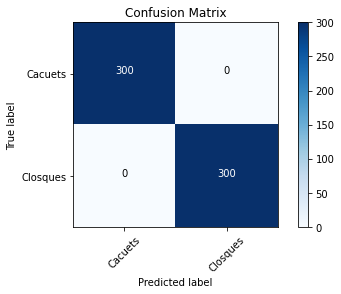

In [ ]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot_labels = ['Cacuets','Closques']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')